<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/unified_multi_stockanomaly_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Standardized Environment Setup

#Uninstall conflicting packages (one-time cleanup)
!pip uninstall -y protobuf tensorflow gym keras torch torchvision torchaudio || true

#Install Core ML & RL Libraries (pinned versions)
!pip install protobuf==3.20.3 tensorflow==2.18.0 stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib matplotlib pandas numpy scipy scikit-learn imblearn

#Install PyTorch with CUDA 12.4 support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

#RAPIDS GPU Acceleration (CUDA 12 compatible)
!pip install --upgrade --force-reinstall \
    dask==2024.11.2 \
    rapids-dask-dependency==24.12.0 \
    cudf-cu12==24.12.0 \
    cuml-cu12==24.12.0 \
    pylibraft-cu12==24.12.0 \
    pylibcudf-cu12==24.12.0 \
    numba==0.61.0


Found existing installation: protobuf 5.29.4
Uninstalling protobuf-5.29.4:
  Successfully uninstalled protobuf-5.29.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.

Looking in indexes: https://download.pytorch.org/whl/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 59.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━

In [1]:
#Set CUDA Paths (clearly once)
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.4'
os.environ['PATH'] += ':/usr/local/cuda-12.4/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-12.4/lib64'

#Verify GPU Availability and Library Versions
import torch, tensorflow as tf, cudf, cuml, dask, gymnasium, stable_baselines3
print("\nGPU & Library Versions")
print("-------------------------")
print(f"PyTorch Version: {torch.__version__}, GPU: {torch.cuda.is_available()}")
print(f"TensorFlow Version: {tf.__version__}, GPU: {tf.config.list_physical_devices('GPU')}")
print(f"cuDF Version: {cudf.__version__}")
print(f"cuML Version: {cuml.__version__}")
print(f"Dask Version: {dask.__version__}")
print(f"Gymnasium Version: {gymnasium.__version__}")
print(f"Stable Baselines3 Version: {stable_baselines3.__version__}")

#Final GPU Check
!nvidia-smi



GPU & Library Versions
-------------------------
PyTorch Version: 2.6.0+cu124, GPU: True
TensorFlow Version: 2.18.0, GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuDF Version: 24.12.00
cuML Version: 24.12.00
Dask Version: 2024.11.2
Gymnasium Version: 1.1.1
Stable Baselines3 Version: 2.6.0
Sun Apr  6 08:34:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0 

In [2]:
#Core Imports
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from cuml.cluster import DBSCAN, KMeans as cuKMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [3]:
#Ticker List

tickers = [
    'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'JPM', 'JNJ',
    'XOM', 'V', 'PG', 'UNH', 'MA', 'HD', 'LLY', 'MRK', 'PEP', 'KO',
    'BAC', 'ABBV', 'AVGO', 'PFE', 'COST', 'CSCO', 'TMO', 'ABT', 'ACN', 'WMT',
    'MCD', 'ADBE', 'DHR', 'CRM', 'NKE', 'INTC', 'QCOM', 'NEE', 'AMD', 'TXN',
    'AMGN', 'UPS', 'LIN', 'PM', 'UNP', 'BMY', 'LOW', 'RTX', 'CVX', 'IBM',
    'GE', 'SBUX', 'ORCL'
]

In [4]:
#Utility Functions

def download_stock_data(ticker, period="720d", interval="1h", max_retries=5):
    for attempt in range(1, max_retries + 1):
        try:
            print(f"Attempt {attempt}: Downloading {ticker}...")
            df = yf.download(ticker, period=period, interval=interval)
            if not df.empty:
                df.reset_index(inplace=True)
                df['Symbol'] = ticker
                return df
            raise ValueError("Empty data")
        except Exception as e:
            print(f"Error: {e}. Retrying...")
            time.sleep(attempt * 5)
    print(f"Failed to download {ticker}")
    return None

def fix_dataframe_index(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df.loc[:, ~df.columns.duplicated()]

def compute_technical_indicators(df):
    df = df.copy()
    df = fix_dataframe_index(df)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-6)
    df['RSI'] = 100 - (100 / (1 + rs))
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df.dropna(inplace=True)
    return df

In [5]:
#Anomaly Detection Models
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

def run_autoencoder(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])
    X_tensor = torch.tensor(X, dtype=torch.float32)
    model = Autoencoder(X_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(30):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, X_tensor)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        reconstructions = model(X_tensor)
        mse = torch.mean((X_tensor - reconstructions) ** 2, dim=1).numpy()
        df['anomaly_autoencoder'] = (mse > np.percentile(mse, 95)).astype(int)
    return df

def run_isolation_forest(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = df[['RSI', 'MACD', 'OBV']]
    clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    df['anomaly_iforest'] = clf.fit_predict(X)
    return df

def run_one_class_svm(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])
    svm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
    df['anomaly_ocsvm'] = svm.fit_predict(X)
    return df

def compare_anomaly_methods(df, ticker):
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df, x='Datetime', y='Close', label='Price')
    for method, color in zip(['anomaly_autoencoder', 'anomaly_iforest', 'anomaly_ocsvm'],
                              ['red', 'orange', 'purple']):
        sns.scatterplot(
            data=df[df[method] == 1],
            x='Datetime', y='Close',
            label=method.replace("anomaly_", "").upper(),
            s=40, marker='o', color=color
        )
    plt.title(f'{ticker} Price with Multiple Anomaly Detection Methods')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{ticker.lower()}_compare_anomalies.png")
    plt.close()

In [6]:

#Main Execution
for ticker in tickers:
    df = download_stock_data(ticker)
    if df is None:
        continue
    df = compute_technical_indicators(df)
    df = run_isolation_forest(df)
    df = run_one_class_svm(df)
    df = run_autoencoder(df)

    df['signal'] = 0
    df.loc[df['anomaly_autoencoder'] == 1, 'signal'] = -1
    df.loc[(df['RSI'] < 30) & (df['anomaly_autoencoder'] == 0), 'signal'] = 1

    df.to_csv(f"{ticker.lower()}_anomaly_features.csv", index=False)
    df[df['anomaly_autoencoder'] == 1][['Datetime', 'Close']].to_csv(f"autoencoder_anomalies_{ticker.lower()}.csv", index=False)

    anomaly_counts = {
        "Autoencoder": int(df['anomaly_autoencoder'].sum()),
        "IForest": int(df['anomaly_iforest'].sum()),
        "OCSVM": int(df['anomaly_ocsvm'].sum())
    }
    with open(f"anomaly_counts_{ticker.lower()}.json", 'w') as f:
        json.dump(anomaly_counts, f, indent=2)

    df['overlap_auto_iforest'] = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_iforest'] == 1)).astype(int)
    df['overlap_auto_ocsvm'] = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_ocsvm'] == 1)).astype(int)

    print(f"Anomaly Counts for {ticker}: {anomaly_counts}")
    print(f"Overlap (Autoencoder & IForest): {df['overlap_auto_iforest'].sum()}")
    print(f"Overlap (Autoencoder & OCSVM): {df['overlap_auto_ocsvm'].sum()}")

    compare_anomaly_methods(df, ticker)
    print(f"Completed {ticker}.\n{'-'*50}")

Attempt 1: Downloading AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for AAPL: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 211
Overlap (Autoencoder & OCSVM): 130
Completed AAPL.
--------------------------------------------------
Attempt 1: Downloading TSLA...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for TSLA: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4499}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 110
Completed TSLA.
--------------------------------------------------
Attempt 1: Downloading MSFT...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for MSFT: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4499}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 99
Completed MSFT.
--------------------------------------------------
Attempt 1: Downloading GOOGL...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for GOOGL: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 204
Overlap (Autoencoder & OCSVM): 100
Completed GOOGL.
--------------------------------------------------
Attempt 1: Downloading AMZN...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for AMZN: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 203
Overlap (Autoencoder & OCSVM): 121
Completed AMZN.
--------------------------------------------------
Attempt 1: Downloading NVDA...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for NVDA: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 120
Completed NVDA.
--------------------------------------------------
Attempt 1: Downloading META...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for META: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 210
Overlap (Autoencoder & OCSVM): 132
Completed META.
--------------------------------------------------
Attempt 1: Downloading BRK-B...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for BRK-B: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 105
Completed BRK-B.
--------------------------------------------------
Attempt 1: Downloading JPM...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for JPM: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 215
Overlap (Autoencoder & OCSVM): 102
Completed JPM.
--------------------------------------------------
Attempt 1: Downloading JNJ...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for JNJ: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 218
Overlap (Autoencoder & OCSVM): 121
Completed JNJ.
--------------------------------------------------
Attempt 1: Downloading XOM...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for XOM: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 206
Overlap (Autoencoder & OCSVM): 149
Completed XOM.
--------------------------------------------------
Attempt 1: Downloading V...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for V: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 82
Completed V.
--------------------------------------------------
Attempt 1: Downloading PG...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for PG: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 206
Overlap (Autoencoder & OCSVM): 116
Completed PG.
--------------------------------------------------
Attempt 1: Downloading UNH...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for UNH: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 201
Overlap (Autoencoder & OCSVM): 85
Completed UNH.
--------------------------------------------------
Attempt 1: Downloading MA...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for MA: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4499}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 87
Completed MA.
--------------------------------------------------
Attempt 1: Downloading HD...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for HD: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 213
Overlap (Autoencoder & OCSVM): 120
Completed HD.
--------------------------------------------------
Attempt 1: Downloading LLY...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for LLY: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4499}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 107
Completed LLY.
--------------------------------------------------
Attempt 1: Downloading MRK...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for MRK: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 87
Completed MRK.
--------------------------------------------------
Attempt 1: Downloading PEP...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for PEP: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 227
Overlap (Autoencoder & OCSVM): 144
Completed PEP.
--------------------------------------------------
Attempt 1: Downloading KO...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for KO: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 208
Overlap (Autoencoder & OCSVM): 107
Completed KO.
--------------------------------------------------
Attempt 1: Downloading BAC...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for BAC: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 223
Overlap (Autoencoder & OCSVM): 145
Completed BAC.
--------------------------------------------------
Attempt 1: Downloading ABBV...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for ABBV: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 92
Completed ABBV.
--------------------------------------------------
Attempt 1: Downloading AVGO...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for AVGO: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 202
Overlap (Autoencoder & OCSVM): 99
Completed AVGO.
--------------------------------------------------
Attempt 1: Downloading PFE...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for PFE: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 214
Overlap (Autoencoder & OCSVM): 132
Completed PFE.
--------------------------------------------------
Attempt 1: Downloading COST...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for COST: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 74
Completed COST.
--------------------------------------------------
Attempt 1: Downloading CSCO...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for CSCO: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 202
Overlap (Autoencoder & OCSVM): 95
Completed CSCO.
--------------------------------------------------
Attempt 1: Downloading TMO...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for TMO: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 207
Overlap (Autoencoder & OCSVM): 113
Completed TMO.
--------------------------------------------------
Attempt 1: Downloading ABT...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for ABT: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 209
Overlap (Autoencoder & OCSVM): 131
Completed ABT.
--------------------------------------------------
Attempt 1: Downloading ACN...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for ACN: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 210
Overlap (Autoencoder & OCSVM): 145
Completed ACN.
--------------------------------------------------
Attempt 1: Downloading WMT...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for WMT: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 99
Completed WMT.
--------------------------------------------------
Attempt 1: Downloading MCD...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for MCD: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 92
Completed MCD.
--------------------------------------------------
Attempt 1: Downloading ADBE...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for ADBE: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 124
Completed ADBE.
--------------------------------------------------
Attempt 1: Downloading DHR...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for DHR: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 111
Completed DHR.
--------------------------------------------------
Attempt 1: Downloading CRM...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for CRM: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 203
Overlap (Autoencoder & OCSVM): 104
Completed CRM.
--------------------------------------------------
Attempt 1: Downloading NKE...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for NKE: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 79
Completed NKE.
--------------------------------------------------
Attempt 1: Downloading INTC...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for INTC: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 201
Overlap (Autoencoder & OCSVM): 86
Completed INTC.
--------------------------------------------------
Attempt 1: Downloading QCOM...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for QCOM: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 202
Overlap (Autoencoder & OCSVM): 117
Completed QCOM.
--------------------------------------------------
Attempt 1: Downloading NEE...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for NEE: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 98
Completed NEE.
--------------------------------------------------
Attempt 1: Downloading AMD...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for AMD: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4499}
Overlap (Autoencoder & IForest): 210
Overlap (Autoencoder & OCSVM): 110
Completed AMD.
--------------------------------------------------
Attempt 1: Downloading TXN...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for TXN: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4499}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 108
Completed TXN.
--------------------------------------------------
Attempt 1: Downloading AMGN...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for AMGN: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 94
Completed AMGN.
--------------------------------------------------
Attempt 1: Downloading UPS...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for UPS: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 201
Overlap (Autoencoder & OCSVM): 86
Completed UPS.
--------------------------------------------------
Attempt 1: Downloading LIN...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for LIN: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 202
Overlap (Autoencoder & OCSVM): 125
Completed LIN.
--------------------------------------------------
Attempt 1: Downloading PM...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for PM: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 97
Completed PM.
--------------------------------------------------
Attempt 1: Downloading UNP...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for UNP: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 205
Overlap (Autoencoder & OCSVM): 133
Completed UNP.
--------------------------------------------------
Attempt 1: Downloading BMY...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for BMY: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 201
Overlap (Autoencoder & OCSVM): 87
Completed BMY.
--------------------------------------------------
Attempt 1: Downloading LOW...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for LOW: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4507}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 97
Completed LOW.
--------------------------------------------------
Attempt 1: Downloading RTX...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for RTX: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 226
Overlap (Autoencoder & OCSVM): 139
Completed RTX.
--------------------------------------------------
Attempt 1: Downloading CVX...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for CVX: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 207
Overlap (Autoencoder & OCSVM): 100
Completed CVX.
--------------------------------------------------
Attempt 1: Downloading IBM...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for IBM: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 202
Overlap (Autoencoder & OCSVM): 106
Completed IBM.
--------------------------------------------------
Attempt 1: Downloading GE...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for GE: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
Overlap (Autoencoder & IForest): 215
Overlap (Autoencoder & OCSVM): 102
Completed GE.
--------------------------------------------------
Attempt 1: Downloading SBUX...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for SBUX: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
Overlap (Autoencoder & IForest): 200
Overlap (Autoencoder & OCSVM): 82
Completed SBUX.
--------------------------------------------------
Attempt 1: Downloading ORCL...


[*********************100%***********************]  1 of 1 completed


Anomaly Counts for ORCL: {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
Overlap (Autoencoder & IForest): 202
Overlap (Autoencoder & OCSVM): 122
Completed ORCL.
--------------------------------------------------


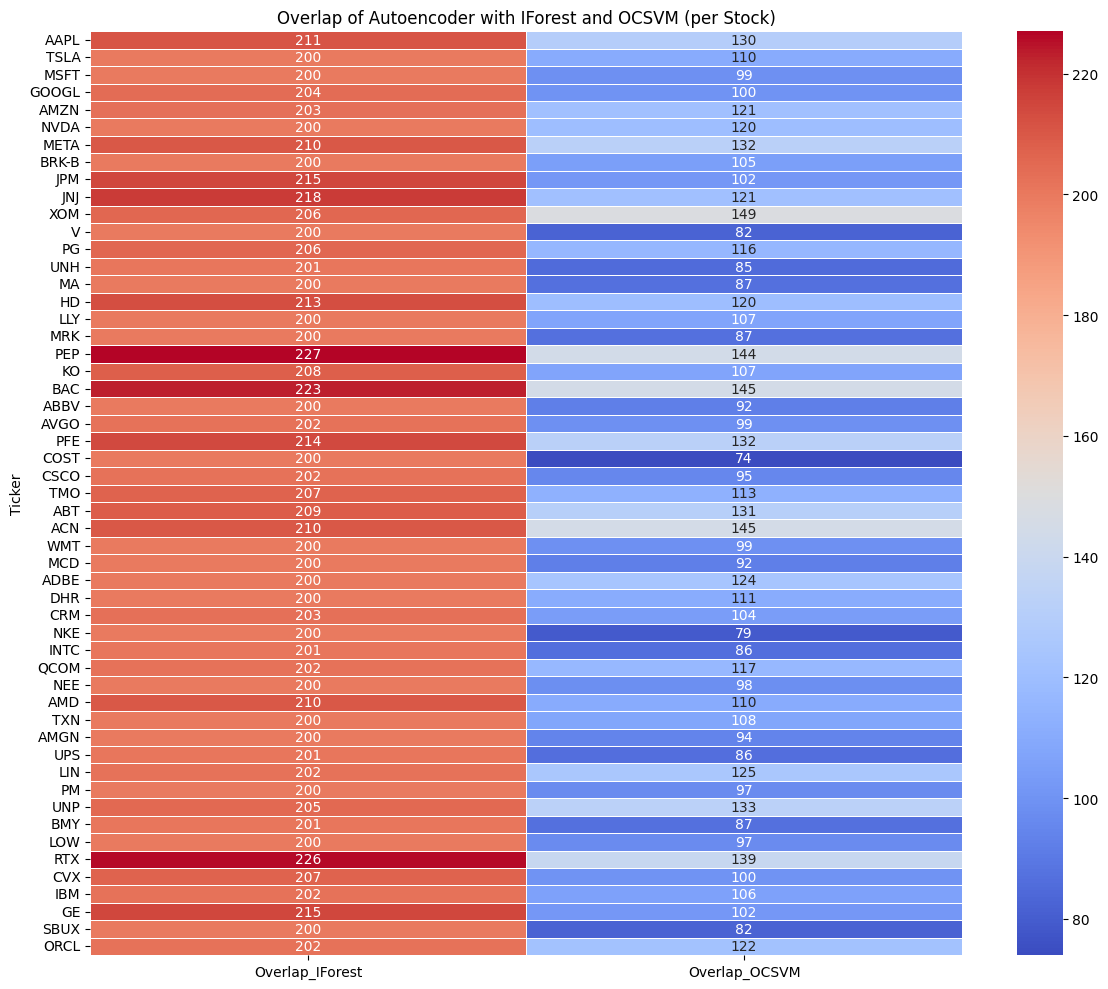

In [7]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

overlap_data = []

for ticker in tickers:
    json_path = f"anomaly_counts_{ticker.lower()}.json"
    csv_path = f"{ticker.lower()}_anomaly_features.csv"

    if not os.path.exists(json_path) or not os.path.exists(csv_path):
        print(f"Skipping {ticker}: Missing file(s)")
        continue

    with open(json_path, 'r') as f:
        counts = json.load(f)

    df = pd.read_csv(csv_path)
    overlap_iforest = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_iforest'] == 1)).sum()
    overlap_ocsvm = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_ocsvm'] == 1)).sum()

    overlap_data.append({
        'Ticker': ticker,
        'Overlap_IForest': overlap_iforest,
        'Overlap_OCSVM': overlap_ocsvm
    })

# Convert to DataFrame
heatmap_df = pd.DataFrame(overlap_data).set_index("Ticker")

# Plot if there's data
if not heatmap_df.empty:
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_df, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
    plt.title("Overlap of Autoencoder with IForest and OCSVM (per Stock)")
    plt.ylabel("Ticker")
    plt.tight_layout()
    plt.savefig("heatmap_overlap.png")
    plt.show()
else:
    print("No overlap data available to display.")


In [8]:
# Calculate total overlap for ranking
heatmap_df['Total_Overlap'] = heatmap_df['Overlap_IForest'] + heatmap_df['Overlap_OCSVM']

# Top 10 most agreed-upon stocks
top_10 = heatmap_df.sort_values(by='Total_Overlap', ascending=False).head(10)
print("\nTop 10 Stocks by Total Overlap (Autoencoder + IForest + OCSVM):")
print(top_10[['Overlap_IForest', 'Overlap_OCSVM', 'Total_Overlap']])

# Bottom 10 least agreed-upon stocks
bottom_10 = heatmap_df.sort_values(by='Total_Overlap', ascending=True).head(10)
print("\nBottom 10 Stocks by Total Overlap (Most Disagreement):")
print(bottom_10[['Overlap_IForest', 'Overlap_OCSVM', 'Total_Overlap']])

# Optionally, save to CSV for later use
ranking_df = pd.concat([top_10, bottom_10])
ranking_df.to_csv("ranked_overlap_stocks.csv")


Top 10 Stocks by Total Overlap (Autoencoder + IForest + OCSVM):
        Overlap_IForest  Overlap_OCSVM  Total_Overlap
Ticker                                               
PEP                 227            144            371
BAC                 223            145            368
RTX                 226            139            365
ACN                 210            145            355
XOM                 206            149            355
PFE                 214            132            346
META                210            132            342
AAPL                211            130            341
ABT                 209            131            340
JNJ                 218            121            339

Bottom 10 Stocks by Total Overlap (Most Disagreement):
        Overlap_IForest  Overlap_OCSVM  Total_Overlap
Ticker                                               
COST                200             74            274
NKE                 200             79            279
SBUX           